# Run Dynamic Connectivity

This script [copied from ISPC] runs dynamic connectivity between target network

## py conversion

In [1]:
#jupyter nbconvert --to python slurm_create-data_preproc.ipynb

## Imports 

In [2]:
import warnings
import sys  
import random
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
import nilearn as nil
# Import a function from BrainIAK to simulate fMRI data
import brainiak.utils.fmrisim as sim  

from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 



from brainiak import image, io
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from nilearn import datasets, plotting
from nilearn.plotting import plot_roi
from nilearn.input_data import NiftiSpheresMasker

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img

from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img

import numpy as np 
import os
import os.path
import scipy.io
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask, unmask
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from copy import deepcopy

# Brainiak # 
from brainiak import image, io 
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import plot_stat_map
%matplotlib inline

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
random.seed(10)

## custom helper functions 

In [4]:
from utils_anal import load_epi_data

## directories 

In [5]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


## main vars 

In [6]:
### sub_list ###
"""

========================================================
===== ~~~ Summary ALL ~~~ ===== 
========================================================
Initially exclude: sub-001, sub-003, sub-011, sub-012, sub-014, sub-015, sub-029 (3+ runs still available tho)
Maybe exclude: sub-014, sub-024, sub-037 (No button presses)
Maybe exclude: sub-020, sub-022, sub-031
total exclude = 10


~~~~~~~ BEHAVIORAL ~~~~~~~~~~
~~~ Summary behavioral ~~~

========================================================
========================================================
No button presses: sub-014, sub-024, sub-037 

========================================================
========================================================
sub-003: Extra row observed for external, which was manually deleted. Should be fine to rerun -- i removed from bad_subs
    - current brushing: 87, TRUE: 88 for THREE runs. last run when there was an issue and scan had to be restarted
    - Scan 6 == 1 run of brushing
    - Scan 7 = 3 runs of brushing 
    - ** no idea when run 7 was started tho! will prolly need to throw out! For now we can process all
sub-014: NO internal OR external bpress, curious! ---should be fixed now
    - changed excel data to include two null columns
    - ALSO only 30 TRs for the second run epi data. i went into the room to adjust runny eyes. Data for this run is not usable. but after should
      be okay if u want to put in the effort 
sub-015: less than 24 runs ---should be fixed now w custom code (but keep out of main run cuz will throw an error otherwise )
    - SUMMARY: need to exclude the office run 3 for fMRI but can include run 3 in behavioral, no data at all for CAKE
    - DID NOT add the 'mov_name' component to the custom code, will need to implment from current iteration
    - **** Use external, ignore internal for now... cuz internal is fuqd. Can preprocess all 7 tho

~~~~~~~ FMRI ~~~~~~~~~~
~~~ Summary fMRI ~~~
sub002: 
 - appended two TRs onto the last run, copied from the third to last TR. should be good to use
sub-003, sub-012, sub-014, sub-015, sub-029: 
 - Five runs usable, will need to incorporate them at some point 
sub-001: external usable - first three runs 

========================================================
========================================================
subject 002: (usable, with adjustment)
    only has 92 INSTEAD OF 94 TRs for the FINAL run of shrek. i think cuz i turned off the scanner
    too soon, which didn't account for 4 TRs of buffer? Yep! end tr is 390, (388, 112179). so duplicate TRs maybe.
    - Temporarily eliminate! or duplicate TRs 
    
sub-003: (usable, 5 runs)
- Scan 6 == 1 run of brushing
- Scan 7 = 3 runs of brushing 
*** need to re-preprocess, then append 6 and 7 together; or just throw out this one cuz idk when scan started

sub-011: (usable)
- not preprocessed 
sub-012 (5 runs usable, one run idk)
- I'll need to post process. It seems that an earbud fell out while reading the directions for run 5 
summary: the fifth run  needs to be discarded. all others are usable.
see the behav data: 
sub_dic['External']['oragami']
{'run-1': {'start_tr': 94, 'end_tr': 188, 'bpress': -1},
 'run-2': {'start_tr': 188, 'end_tr': 282, 'bpress': [100.81657150003593]},
 'run-3': {'start_tr': 282, 'end_tr': 376, 'bpress': [88.26579949003644]},
 'run-4': {'start_tr': 378,
  'end_tr': 472,
  }
- you can see taht the start TR is 94!! that's becuz i had to go into the scan room during the instructions screen.
- this is producing the wrong indexing -- becuz the scan doesn't contain enough TRs according to the behavioral data:
    - run 4 of shrek only has 12 TRs because we start at TR 94.
- im not sure when the scan actually started, but if i wanted to try to include i could 
    set the start TR to 1 -- essentially suggesting that the first TR was collected on the external 'waiting 
    for TR' flip. might as well try at some point, but exclude for now
    - this would involve just subtracting 94 from all start end end TRs i think
See the excel behavioral file for further notes notes
this 

sub-014 - no button press data and 7 runs (5 runs usable, but no bpress)
    - same problem as above -- i went into the scanner room during the instructions period to wipe eyes
    {'run-1': {'start_tr': 237, 'end_tr': 323, 'bpress': -1},
     'run-2': {'start_tr': 329, 'end_tr': 415, 'bpress': -1},
     'run-3': {'start_tr': 417, 'end_tr': 503, 'bpress': -1},
     'run-4': {'start_tr': 509, 'end_tr': 595, 'bpress': -1}}

sub-029: (5 runs usable)
- scanner malfunction, maybe possible to stitch together run 6 cuz i started on the *tenth* TR

========================================================
========================================================
Left handed: (sub-020, sub-022, sub-032)
    - sub-020: also no button presses, appeared to be awake tho
    - sub-022: lefty
    - sub-031: ambidexterious, great data
========================================================
========================================================
"""

## adjusted sublist 
sub_list = [
    'sub-002', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010',
    'sub-013','sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028','sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040'
]

## ALL SUBLIST
sub_list = [
    'sub-002', 'sub-003', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010', 'sub-012',
    'sub-013','sub-014', 'sub-015', 'sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028', 'sub-029', 'sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040', 'sub-041'
]
###### LOADING VARS #######




In [7]:
## TR length of each movie ## 
mov_len_dic = {
'oragami' :  82,
'shrek' : 90,
'sherlock' : 98,
'brushing' : 88,
'cake' : 99,
'office' : 102    
}

voxel_num = 112179

num_parc = 400


# load atlas 

In [8]:
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc)
atlas_filename = dataset.maps
labels = dataset.labels

print(f"Atlas ROIs are located in nifti image (4D) at: {atlas_filename}")

Atlas ROIs are located in nifti image (4D) at: /usr/people/isaacrc/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


In [9]:
labels[:3]

array([b'7Networks_LH_Vis_1', b'7Networks_LH_Vis_2',
       b'7Networks_LH_Vis_3'], dtype='|S37')

In [10]:
# Load  sample data for resampling
resamp_run = load_epi_data(fmri_prep, 'sub-007', 2, "MNI")
# Load parcellation
d = nib.load(atlas_filename)
atlas_nii = resample_to_img(d, resamp_run, interpolation='nearest')
# Get parcellation fdata
atlas_img = atlas_nii.get_fdata()
# paracellations scheme
print(f'count parc:{len(np.unique(atlas_nii.get_fdata()))}')
print("shape of atlas nii object", atlas_img.shape)



Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:401
shape of atlas nii object (78, 93, 65)


### plot

In [11]:
"""
## Set the ROI num ## 
roi_num = 183
print("Begin Parc", roi_num)

# How many voxels for this ROI? #
num_voxels = np.sum(atlas_img == roi_num)
print("num voxels in one parcel:", num_voxels)
# Create an empty that is the shape of d
roi_tem = np.zeros(atlas_nii.shape)
# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)
roi_tem[atlas_img == roi_num] = 1
# Create a nift image of the mask
roi_img = nib.Nifti1Image(roi_tem, affine = atlas_nii.affine, header = atlas_nii.header)
roi_name = labels[roi_num]
print(roi_name[10:].decode("utf-8"))
#nib.save(roi_img, rois_dir+'/'+ roi_name.decode("utf-8"))

plot_roi(roi_img)
"""

'\n## Set the ROI num ## \nroi_num = 183\nprint("Begin Parc", roi_num)\n\n# How many voxels for this ROI? #\nnum_voxels = np.sum(atlas_img == roi_num)\nprint("num voxels in one parcel:", num_voxels)\n# Create an empty that is the shape of d\nroi_tem = np.zeros(atlas_nii.shape)\n# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)\nroi_tem[atlas_img == roi_num] = 1\n# Create a nift image of the mask\nroi_img = nib.Nifti1Image(roi_tem, affine = atlas_nii.affine, header = atlas_nii.header)\nroi_name = labels[roi_num]\nprint(roi_name[10:].decode("utf-8"))\n#nib.save(roi_img, rois_dir+\'/\'+ roi_name.decode("utf-8"))\n\nplot_roi(roi_img)\n'

In [12]:
# Load in network labels
label_fn = 'brainiak-aperture-isc-data/Schaefer2018_400Parcels_17Networks_order.txt'
with open(label_fn) as f:
    networks = [' '.join((label.split('_')[1][0], label.split('_')[2]))
                for label in f.readlines()]
    
# Get sorted unique network labels
idxs = np.unique(networks, return_index=True)[1]
network_labels = [networks[idx] for idx in sorted(idxs)]

# Get middle index for each network for plotting
network_idxs = [int(np.median([i for i, n in enumerate(networks)
                                if n == network]))
                for network in network_labels]

In [13]:
network_labels

['L VisCent',
 'L VisPeri',
 'L SomMotA',
 'L SomMotB',
 'L DorsAttnA',
 'L DorsAttnB',
 'L SalVentAttnA',
 'L SalVentAttnB',
 'L LimbicB',
 'L LimbicA',
 'L ContA',
 'L ContB',
 'L ContC',
 'L DefaultA',
 'L DefaultB',
 'L DefaultC',
 'L TempPar',
 'R VisCent',
 'R VisPeri',
 'R SomMotA',
 'R SomMotB',
 'R DorsAttnA',
 'R DorsAttnB',
 'R SalVentAttnA',
 'R SalVentAttnB',
 'R LimbicB',
 'R LimbicA',
 'R ContA',
 'R ContB',
 'R ContC',
 'R DefaultA',
 'R DefaultB',
 'R DefaultC',
 'R TempPar']

# Select network for analysis and plot

In [119]:
# Get labels for parcels in left DMN A network
net_lab_1 = 'L DefaultB' #'L DefaultB'  #'R ContA' #R DorsAttnB  #R VisPeri  #R SalVentAttnA #'R TempPar' #'L SomMotA'
net_lab_2 = 'R ContA' #'L DefaultB'  #'R ContA' #R DorsAttnB  #R VisPeri  #R SalVentAttnA #'R TempPar' #'L SomMotA'


## Target Conditions
targ_cond = "Internal"

## movie repetitions ##
#m_reps = 1
targ_run = 4

## Get labels associated with the target network ## 
targ_net_1 = (np.array(networks) == net_lab_1).nonzero()[0] + 1
targ_net_2 = (np.array(networks) == net_lab_2).nonzero()[0] + 1

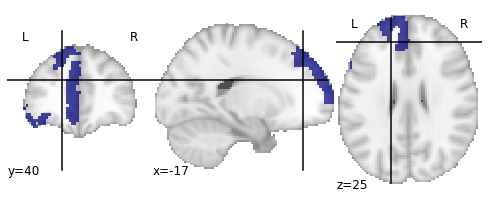

In [120]:
# Create an empty that is the shape of d
roi_tem = np.zeros(atlas_nii.shape)
# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)
for parcel in targ_net:
    roi_tem[atlas_img == parcel] = 1
    
# Create a nift image of the mask
roi_img = nib.Nifti1Image(roi_tem, affine = atlas_nii.affine, header = atlas_nii.header)
#nib.save(roi_img, rois_dir+'/'+ roi_name.decode("utf-8"))


mPFC_coords = (10,10, 45)
pcc_coords = (10,-40, 45)

#plot_roi(roi_img,cut_coords = pcc_coords)
plot_roi(roi_img)

# variables

In [121]:
# Get labels for parcels in left DMN A network
vox_roi = len(np.where(roi_tem ==1)[2])
print(f'using {net_lab} with {vox_roi} voxels')

using L DefaultB with 3404 voxels


In [122]:
## Load mask
## mask image ##
mask_img = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
#mask_img = nib.load(mask_dir + "/shaef_gm_MNI_mask.nii")


## how many TRs on the end? ## 
tr_buffer = 4 

# cuttoff the countdown 
trim_start = 4 # cuts off first 4 TRs

## number of runs to iterate over
epi_runs = 6

## load the runs to be included for each subject ## 
sub_run_inc = np.load(behav_dir + '/sub_run_inc.npy', allow_pickle = True).item()

## how many TRs to iterate around the button press
tr_range = np.arange(-3,10)

# this is the window which gannot be impeded by a second button press 
range_len = len(tr_range)
no_interfere = len(np.where(tr_range>0)[0])
print(f'total TRs to be extracted around the bpress: {range_len}\n total trs extracted post bpress: {no_interfere}')

total TRs to be extracted around the bpress: 13
 total trs extracted post bpress: 9


### begin

In [123]:
m_rep_int = {}
m_rep_ext = {}

for run in range(1, targ_run + 1):
    external = {}
    internal = {}
    
    for sub in sub_list:
        ### fMRI load ###
        sub_dic_fmri = np.load(f'{preproc_dir}/{sub}_fwhm6_conf.npy', allow_pickle=True).item()
        print(f'start {sub}')
        ## BEHAVIORAL ##
        sub_dic_behav = np.load(os.path.join(behav_dir, f'{sub}_behav.npy'), allow_pickle=True).item()

        # Create subject number 
        sub_num = int(sub[-3:])

        for epi_index in range(0, epi_runs):
            # Add one to the index to create 1-6 runs
            epi_run = epi_index + 1

            # check if run is to be included 
            if not sub_run_inc[sub][epi_run]: continue

            # Get the movie name
            mov_name = sub_dic_behav['mov_order'][epi_index]

            # Create an empty array for the movie runs, append four TRs to account for the 4 trailing TRs, subtract
            # the quantity of TRs that we are trimming from the front 
            mov_runs = np.zeros((range_len))

            print(f'movie: {mov_name} with shape {mov_runs.shape}')

            # Get the fMRI run for the current epi_index
            fmri_run = sub_dic_fmri[epi_run]

            # Loop over runs
            #for run in range(1, m_reps + 1):
            # Is this an internal or external run?
            key = 'External' if (sub_num % 2 == 1 and epi_index < 3) or (sub_num % 2 == 0 and epi_index >= 3) else 'Internal'

            ### only do internal for now ##
            #if key != targ_cond: continue

            ## get behavioral data
            bpress_arr = sub_dic_behav[key][mov_name][f'run-{str(run)}']['bpress']

            ## continue if no button presses
            if bpress_arr == -1:
                print(f'NO button presses {sub} {run}\n')
                continue


            # Begin slicing fMRI data #
            start_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['start_tr']
            end_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['end_tr']
            run_slice = fmri_run[(start_tr + trim_start):end_tr, :]
            print(f'run{run} bpress count is: {len(bpress_arr)}')
            print(f'start tr {start_tr}, end TR {end_tr}, length of fMRI run {fmri_run.shape}')
            assert fmri_run.shape[0] >= end_tr, 'end TR is greater than fMRI TRs available'

            # calculate differences between button presses, and append the time stamp of the end of scan
            difs = np.diff(np.hstack((bpress_arr, (end_tr - start_tr) * 1.5)))

            ## empty array to append if TR doesn't exist or conflicts with another button pres!
            empty = np.zeros((run_slice.shape[1])) ## number of voxels

            bpress_mat = []
            for idx, bpress in enumerate(bpress_arr):
                # Find the tr that each onset occured - convert from seconds to TR
                bpress_tr = round(bpress/1.5)
                print(f'\ntime of bpress {bpress},  tr is: {bpress_tr}, and next tr is {difs[idx]} away')
                assert bpress_tr < end_tr, print('TR extends past fMRI data, what on earth is going on!')

                temp = []
                ## for each tr in the TR range [likely this is 12 total trs]
                for num_tr in tr_range:
                    try:
                        # IF tr exists in the range of TRs add to temp array before averaging in the next step
                        current_bpress_tr = run_slice[bpress_tr+num_tr]
                        # if no error is thrown, run a check
                        # if the distance between the current and next tR is less than 1.5*6 seconds, do not extract that data
                        # and fill with empty zeros to be averaged over later
                        # 6 is the number of TRs ahead. we convert to seconds by multiplying by 1.5
                        if difs[idx] < 1.5 * num_tr:
                            temp.append(empty)
                            #print(f'INTERFERE DIF: cur TR is:{num_tr}, next bpress is {int(difs[idx] /1.5)} trs away')
                        else:
                            # add the correct voxel activation for the given TR 
                            temp.append(current_bpress_tr)
                            #print(f'CORRECT {current_bpress_tr[:3]}, length of TR activ is {len(current_bpress_tr)}')

                    except:
                        # if it doesn't exist, add an empty vector
                        temp.append(empty)
                        #print(f'INTERFERE Out of BNDS: bpress_tr {bpress_tr}, index {bpress_tr+num_tr}; total TRs {end_tr - start_tr}')
                    #print(f'FINISHED the {num_tr} TR')
                bpress_mat.append(temp)
                #print('FINISHED ONE BUTTN PRESS\n\n')

            ## convert list into numpy array
            bpress_mat = np.dstack(bpress_mat)
            print(f'num bpress: {len(bpress_arr)}, TRs: {bpress_mat.shape[0]}, voxels: {bpress_mat.shape[1]}')
            print(f'shape of bpress for {sub} is {bpress_mat.shape}')
            ## check that we have activation for at least one button press
            assert np.any(bpress_mat), f'NO BPRESSES FOR {sub}'

            ## once we've finished iterating over all button press, average each bpress matrix element-wise!
            #bpress_mat_av = np.mean(bpress_mat, axis =2)
            bpress_mat_av = np.nanmean(np.where(bpress_mat != 0, bpress_mat, np.nan), axis =2)
            # re-insert zeros after averaging, ignoring TRs that had no activation
            bpress_mat_av = np.where(bpress_mat_av != np.nan, bpress_mat_av, 0)

            # convert back to whole brain 4D image, instead of 2d
            bpress_nii = unmask(bpress_mat_av, mask_img)
            print(f'convert bpress averages back to nii: {bpress_nii.shape}')

            # Convert to 4d numpy array
            f_dat_4d = bpress_nii.get_fdata()
            
            targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

            # loop through all TRs and get the target voxel pattern for the first network #
            bpress_pat_1 = np.column_stack([f_dat_4d[atlas_img == parcel, :].T
                            for parcel in targ_net_1])
            
            # loop through all TRs and get the target voxel pattern for the second network #
            bpress_pat_2 = np.column_stack([f_dat_4d[atlas_img == parcel, :].T
                            for parcel in targ_net_2])
            
            ## zscore and average across voxels before dyn connectivity
            bpress_trs_1 = np.mean(zscore(bpress_pat_1, axis =1), axis =1)
            bpress_trs_2 = np.mean(zscore(bpress_pat_2, axis =1), axis =1)
            
            ## connextivty ##
            dyn_con = np.multiply(bpress_trs_1, bpress_trs_2)
            
            print(f'averaged and zscore ROIs: {bpress_trs_1.shape}\n\n')

            # expand to three dimensions for stacking 
            #bpress_trs_exp = np.expand_dims(dyn_con, 1)

            # Stack the run slice with the mov_runs array
            #mov_runs = np.dstack((mov_runs, bpress_pat))
            mov_runs = np.vstack((mov_runs, dyn_con))
            print(f'stacked! {mov_runs.shape}')
            ## shave off zeros ##
            if np.all(mov_runs[0] == 0):
                mov_runs = mov_runs[1:]
            #assert mov_runs.shape[2] == 4, 'wrong numer of repetitions'

            # set outer loop #
            if key == 'External':
                target_dict = external
            else:
                target_dict = internal

            if mov_name not in target_dict:
                target_dict[mov_name] = mov_runs
            else:
                #mov_runs = np.expand_dims(mov_runs, 3)
                target_dict[mov_name] = np.dstack((target_dict[mov_name], mov_runs))
                #target_dict[mov_name] = np.vstack((target_dict[mov_name], mov_runs))
        print(f'\n subject {sub} finished \n')

    ## save into a repetition dictionary ## 
    m_rep_ext[run] = external
    m_rep_int[run] = internal



    print('done')
        
            
            
            
            
            
            

start sub-002
movie: shrek with shape (13,)
NO button presses sub-002 1

movie: sherlock with shape (13,)
run1 bpress count is: 2
start tr 7, end TR 109, length of fMRI run (417, 112179)

time of bpress 10.1,  tr is: 7, and next tr is 0.0 away

time of bpress 10.1,  tr is: 7, and next tr is 142.9 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 2)


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: Mean of empty slice


convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run1 bpress count is: 2
start tr 7, end TR 93, length of fMRI run (355, 112179)

time of bpress 10.1,  tr is: 7, and next tr is 0.0 away

time of bpress 10.1,  tr is: 7, and next tr is 118.9 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run1 bpress count is: 2
start tr 8, end TR 114, length of fMRI run (437, 112179)

time of bpress 34.00292439600162,  tr is: 23, and next tr is 47.079010672998265 away

time of bpress 81.08193506899988,  tr is: 54, and next tr is 77.91806493100012 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
mo

num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-004 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-004 finished 

start sub-005
movie: cake with shape (13,)
NO button presses sub-005 1

movie: office with shape (13,)
NO button presses sub-005 1

movie: brushing with shape (13,)
run1 bpress count is: 1
start tr 14, end TR 106, length of fMRI run (402, 112179)

time of bpress 68.44533528498141,  tr is: 46, and next tr is 69.55466471501859 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-005 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run1 bpress count is: 1
start tr 11, end TR 97, length of fMRI run (364, 112179)

time of bpress 87.99744509195443,  tr is: 59, and next tr is 41.00255490804557 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for 

num bpress: 9, TRs: 13, voxels: 112179
shape of bpress for sub-007 is (13, 112179, 9)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-007 finished 

start sub-008
movie: brushing with shape (13,)
run1 bpress count is: 1
start tr 19, end TR 111, length of fMRI run (404, 112179)

time of bpress 123.01615735399537,  tr is: 82, and next tr is 14.983842646004632 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-008 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run1 bpress count is: 2
start tr 10, end TR 116, length of fMRI run (443, 112179)

time of bpress 98.76934708002955,  tr is: 66, and next tr is 44.61301517894026 away

time of bpress 143.3823622589698,  tr is: 96, and next tr is 15.617637741030194 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-008 is (13, 112179, 2)
con

num bpress: 16, TRs: 13, voxels: 112179
shape of bpress for sub-010 is (13, 112179, 16)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
NO button presses sub-010 1

movie: cake with shape (13,)
run1 bpress count is: 2
start tr 16, end TR 119, length of fMRI run (434, 112179)

time of bpress 42.094576528063044,  tr is: 28, and next tr is 65.93310202495195 away

time of bpress 108.027678553015,  tr is: 72, and next tr is 46.472321446985006 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-010 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run1 bpress count is: 2
start tr 10, end TR 102, length of fMRI run (381, 112179)

time of bpress 42.07574843603652,  tr is: 28, and next tr is 12.757981381961145 away

time of bpress 54.833729817997664,  tr is: 37, and next tr is 83.1662701

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run1 bpress count is: 10
start tr 7, end TR 93, length of fMRI run (354, 112179)

time of bpress 26.58962846803479,  tr is: 18, and next tr is 1.887918832944706 away

time of bpress 28.477547300979495,  tr is: 19, and next tr is 2.614017013926059 away

time of bpress 31.091564314905554,  tr is: 21, and next tr is 11.899016562150791 away

time of bpress 42.990580877056345,  tr is: 29, and next tr is 13.393006732920185 away

time of bpress 56.38358760997653,  tr is: 38, and next tr is 1.5860890680924058 away

time of bpress 57.969676678068936,  tr is: 39, and next tr is 3.5558775840327144 away

time of bpress 61.52555426210165,  tr is: 41, and next tr is 22.13401906681247 away

time of bpress 83.65957332891412,  tr is: 56, and next tr is 3.9270186591893435 away

time of bpress 87.58659198810346,  tr is: 58, and next tr is 14.187000395962968 away

time o

num bpress: 15, TRs: 13, voxels: 112179
shape of bpress for sub-017 is (13, 112179, 15)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-017 finished 

start sub-018
movie: sherlock with shape (13,)
run1 bpress count is: 4
start tr 19, end TR 121, length of fMRI run (439, 112179)

time of bpress 27.35727288199996,  tr is: 18, and next tr is 18.659005852008704 away

time of bpress 46.016278734008665,  tr is: 31, and next tr is 27.936011583995423 away

time of bpress 73.95229031800409,  tr is: 49, and next tr is 45.01199631000054 away

time of bpress 118.96428662800463,  tr is: 79, and next tr is 34.03571337199537 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-018 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run1 bpress count is: 7
start tr 9, end TR 95, length of fMRI run (363, 112179)

t

num bpress: 11, TRs: 13, voxels: 112179
shape of bpress for sub-019 is (13, 112179, 11)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
run1 bpress count is: 13
start tr 7, end TR 110, length of fMRI run (427, 112179)

time of bpress 12.20345509100298,  tr is: 8, and next tr is 6.897989940000116 away

time of bpress 19.101445031003095,  tr is: 13, and next tr is 6.762008331003017 away

time of bpress 25.863453362006112,  tr is: 17, and next tr is 8.000994336995063 away

time of bpress 33.864447699001175,  tr is: 23, and next tr is 9.93204640300246 away

time of bpress 43.796494102003635,  tr is: 29, and next tr is 8.47595603299851 away

time of bpress 52.272450135002146,  tr is: 35, and next tr is 11.38801270800468 away

time of bpress 63.660462843006826,  tr is: 42, and next tr is 8.172000898994156 away

time of bpress 71.83246374200098,  tr is: 48, and next tr is 17.096050356994965 away

time of bpr

num bpress: 7, TRs: 13, voxels: 112179
shape of bpress for sub-022 is (13, 112179, 7)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run1 bpress count is: 1
start tr 8, end TR 114, length of fMRI run (471, 112179)

time of bpress 24.906076277024113,  tr is: 17, and next tr is 134.0939237229759 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-022 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run1 bpress count is: 2
start tr 8, end TR 100, length of fMRI run (378, 112179)

time of bpress 111.83011578698643,  tr is: 75, and next tr is 6.898887810995802 away

time of bpress 118.72900359798223,  tr is: 79, and next tr is 19.270996402017772 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-022 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 6

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-024 finished 

start sub-025
movie: brushing with shape (13,)
NO button presses sub-025 1

movie: cake with shape (13,)
run1 bpress count is: 4
start tr 8, end TR 111, length of fMRI run (429, 112179)

time of bpress 19.675590076018125,  tr is: 13, and next tr is 14.600025931140408 away

time of bpress 34.27561600715853,  tr is: 23, and next tr is 11.304951628902927 away

time of bpress 45.58056763606146,  tr is: 30, and next tr is 54.96901672007516 away

time of bpress 100.54958435613662,  tr is: 67, and next tr is 53.95041564386338 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-025 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
NO button presses sub-025 1

movie: oragami with shape (13,)
run1 bpress count is: 9
start tr 11, end TR 97, lengt

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run1 bpress count is: 4
start tr 8, end TR 114, length of fMRI run (443, 112179)

time of bpress 29.161837472813204,  tr is: 19, and next tr is 30.52500702510588 away

time of bpress 59.68684449791908,  tr is: 40, and next tr is 43.884008954046294 away

time of bpress 103.57085345196538,  tr is: 69, and next tr is 46.126995734870434 away

time of bpress 149.6978491868358,  tr is: 100, and next tr is 9.30215081316419 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-027 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run1 bpress count is: 2
start tr 8, end TR 100, length of fMRI run (379, 112179)

time of bpress 83.76307602622546,  tr is: 56, and next tr is 42.40702657587826 away

time of bpress 126.17010260210373,  tr is: 84, a

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-029 finished 

start sub-030
movie: oragami with shape (13,)
run1 bpress count is: 1
start tr 19, end TR 105, length of fMRI run (379, 112179)

time of bpress 53.38652355992235,  tr is: 36, and next tr is 75.61347644007765 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-030 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run1 bpress count is: 3
start tr 9, end TR 111, length of fMRI run (422, 112179)

time of bpress 18.556125592906028,  tr is: 12, and next tr is 18.451001573121175 away

time of bpress 37.0071271660272,  tr is: 25, and next tr is 93.59700779104605 away

time of bpress 130.60413495707326,  tr is: 87, and next tr is 22.395865042926744 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-030 is (13, 112179, 3)
conv

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run1 bpress count is: 2
start tr 7, end TR 113, length of fMRI run (450, 112179)

time of bpress 52.47381783183664,  tr is: 35, and next tr is 45.45600579911843 away

time of bpress 97.92982363095507,  tr is: 65, and next tr is 61.07017636904493 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-032 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run1 bpress count is: 1
start tr 8, end TR 102, length of fMRI run (397, 112179)

time of bpress 103.59442957490683,  tr is: 69, and next tr is 37.405570425093174 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-032 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)


num bpress: 19, TRs: 13, voxels: 112179
shape of bpress for sub-033 is (13, 112179, 19)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-033 finished 

start sub-034
movie: shrek with shape (13,)
run1 bpress count is: 12
start tr 11, end TR 105, length of fMRI run (393, 112179)

time of bpress 12.215506280772388,  tr is: 8, and next tr is 7.126021558884531 away

time of bpress 19.34152783965692,  tr is: 13, and next tr is 9.715054646134377 away

time of bpress 29.056582485791296,  tr is: 19, and next tr is 9.985931815113872 away

time of bpress 39.04251430090517,  tr is: 26, and next tr is 8.018897371832281 away

time of bpress 47.06141167273745,  tr is: 31, and next tr is 9.55210047820583 away

time of bpress 56.61351215094328,  tr is: 38, and next tr is 12.61800941079855 away

time of bpress 69.23152156174183,  tr is: 46, and next tr is 12.240060311276466 away

time of bpress 81.4715818730183,  tr is: 54, and next 

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run1 bpress count is: 6
start tr 10, end TR 102, length of fMRI run (381, 112179)

time of bpress 28.463241084944457,  tr is: 19, and next tr is 19.24701705109328 away

time of bpress 47.71025813603774,  tr is: 32, and next tr is 20.00397467566654 away

time of bpress 67.71423281170428,  tr is: 45, and next tr is 30.111013217363507 away

time of bpress 97.82524602906778,  tr is: 65, and next tr is 11.443004739936441 away

time of bpress 109.26825076900423,  tr is: 73, and next tr is 15.7290099686943 away

time of bpress 124.99726073769853,  tr is: 83, and next tr is 13.002739262301475 away
num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-035 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
run1 bpress count is: 8
start tr 7, end TR 11

num bpress: 14, TRs: 13, voxels: 112179
shape of bpress for sub-038 is (13, 112179, 14)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run1 bpress count is: 3
start tr 10, end TR 102, length of fMRI run (391, 112179)

time of bpress 16.42482410185039,  tr is: 11, and next tr is 40.83903392218053 away

time of bpress 57.263858024030924,  tr is: 38, and next tr is 20.008987148758024 away

time of bpress 77.27284517278895,  tr is: 52, and next tr is 60.72715482721105 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-038 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
NO button presses sub-038 1

movie: cake with shape (13,)
run1 bpress count is: 1
start tr 11, end TR 114, length of fMRI run (431, 112179)

time of bpress 74.5621471889317,  tr is: 50, and next tr is 79.937852811

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run1 bpress count is: 6
start tr 8, end TR 94, length of fMRI run (361, 112179)

time of bpress 17.67814728501253,  tr is: 12, and next tr is 12.618125921930186 away

time of bpress 30.296273206942715,  tr is: 20, and next tr is 8.897014623973519 away

time of bpress 39.19328783091623,  tr is: 26, and next tr is 14.886994605069049 away

time of bpress 54.08028243598528,  tr is: 36, and next tr is 28.663019553991035 away

time of bpress 82.74330198997632,  tr is: 55, and next tr is 27.63889082300011 away

time of bpress 110.38219281297643,  tr is: 74, and next tr is 18.617807187023573 away
num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-041 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run1 bpress count is: 3
start tr 8, end TR 

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
NO button presses sub-003 2

movie: office with shape (13,)
run2 bpress count is: 3
start tr 118, end TR 224, length of fMRI run (445, 112179)

time of bpress 22.524771973025054,  tr is: 15, and next tr is 73.24309701897437 away

time of bpress 95.76786899199942,  tr is: 64, and next tr is 41.669972797011724 away

time of bpress 137.43784178901115,  tr is: 92, and next tr is 21.562158210988855 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-003 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
run2 bpress count is: 8
start tr 110, end TR 213, length of fMRI run (429, 112179)

time of bpress 52.08676593902055,  tr is: 35, and next tr is 6.0820114749949425 away

time of bpress 58.168777414015494,  tr is: 39, and next tr is 8.148981471

start sub-006
movie: oragami with shape (13,)
run2 bpress count is: 3
start tr 105, end TR 191, length of fMRI run (374, 112179)

time of bpress 38.843032967997715,  tr is: 26, and next tr is 51.891013246029615 away

time of bpress 90.73404621402733,  tr is: 60, and next tr is 29.38800416199956 away

time of bpress 120.12205037602689,  tr is: 80, and next tr is 8.877949623973109 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-006 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run2 bpress count is: 1
start tr 119, end TR 221, length of fMRI run (436, 112179)

time of bpress 43.14068666205276,  tr is: 29, and next tr is 109.85931333794724 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-006 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run2 bpress count is: 1
start tr 113, end TR 215, length of fMRI run (426, 112179)

time of bpress 84.26271919405553,  tr is: 56, and next tr is 68.73728080594447 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-008 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-008 finished 

start sub-009
movie: cake with shape (13,)
run2 bpress count is: 4
start tr 116, end TR 219, length of fMRI run (428, 112179)

time of bpress 13.605872538988478,  tr is: 9, and next tr is 54.65400976908859 away

time of bpress 68.25988230807707,  tr is: 46, and next tr is 36.79191574896686 away

time of bpress 105.05179805704392,  tr is: 70, and next tr is 35.89102208300028 away

time of bpress 140.9428201400442,  tr is: 94, and next tr is 13.557179859955795 away
num bp

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run2 bpress count is: 2
start tr 115, end TR 221, length of fMRI run (443, 112179)

time of bpress 58.329757264000364,  tr is: 39, and next tr is 41.010997509001754 away

time of bpress 99.34075477300212,  tr is: 66, and next tr is 59.65924522699788 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-012 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run2 bpress count is: 2
start tr 103, end TR 189, length of fMRI run (388, 112179)

time of bpress 83.09843941102736,  tr is: 55, and next tr is 23.27699343196582 away

time of bpress 106.37543284299318,  tr is: 71, and next tr is 22.624567157006823 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-012 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93,

num bpress: 16, TRs: 13, voxels: 112179
shape of bpress for sub-015 is (13, 112179, 16)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-015 finished 

start sub-016
movie: cake with shape (13,)
run2 bpress count is: 2
start tr 115, end TR 218, length of fMRI run (429, 112179)

time of bpress 53.76876244391315,  tr is: 36, and next tr is 32.0219879001379 away

time of bpress 85.79075034405105,  tr is: 57, and next tr is 68.70924965594895 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-016 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run2 bpress count is: 4
start tr 103, end TR 195, length of fMRI run (382, 112179)

time of bpress 25.656267660902813,  tr is: 17, and next tr is 34.50299608008936 away

time of bpress 60.15926374099217,  tr is: 40, and next tr is 37.618004615884274 away

tim

num bpress: 8, TRs: 13, voxels: 112179
shape of bpress for sub-018 is (13, 112179, 8)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run2 bpress count is: 3
start tr 106, end TR 198, length of fMRI run (394, 112179)

time of bpress 50.700541815996985,  tr is: 34, and next tr is 15.136006585002178 away

time of bpress 65.83654840099916,  tr is: 44, and next tr is 14.380993600003421 away

time of bpress 80.21754200100258,  tr is: 53, and next tr is 57.782457998997415 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-018 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run2 bpress count is: 1
start tr 119, end TR 225, length of fMRI run (447, 112179)

time of bpress 133.95732287000283,  tr is: 89, and next tr is 25.042677129997173 away
num bpress: 1, TRs: 13, voxels: 112179
sha

start sub-021
movie: cake with shape (13,)
run2 bpress count is: 6
start tr 128, end TR 231, length of fMRI run (440, 112179)

time of bpress 27.541605043923482,  tr is: 18, and next tr is 27.35999318002723 away

time of bpress 54.901598223950714,  tr is: 37, and next tr is 14.944002920063213 away

time of bpress 69.84560114401393,  tr is: 47, and next tr is 12.030115494970232 away

time of bpress 81.87571663898416,  tr is: 55, and next tr is 14.32088939100504 away

time of bpress 96.1966060299892,  tr is: 64, and next tr is 47.55601989896968 away

time of bpress 143.75262592895888,  tr is: 96, and next tr is 10.747374071041122 away
num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-021 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run2 bpress count is: 2
start tr 113, end TR 219, length of fMRI run (434, 112179)

time of bpress 14.035803786013275,  tr is: 9, and nex

num bpress: 9, TRs: 13, voxels: 112179
shape of bpress for sub-022 is (13, 112179, 9)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
run2 bpress count is: 3
start tr 110, end TR 213, length of fMRI run (423, 112179)

time of bpress 34.54977041797247,  tr is: 23, and next tr is 61.728007873985916 away

time of bpress 96.27777829195838,  tr is: 64, and next tr is 32.847017000080086 away

time of bpress 129.12479529203847,  tr is: 86, and next tr is 25.37520470796153 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-022 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-022 finished 

start sub-023
movie: sherlock with shape (13,)
run2 bpress count is: 2
start tr 116, end TR 218, length of fMRI run (430, 112179)

time of bpress 19.549692173022777,  tr is: 13, and next tr is 60.10498332802672 away

ti

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run2 bpress count is: 1
start tr 115, end TR 221, length of fMRI run (435, 112179)

time of bpress 135.030286927009,  tr is: 90, and next tr is 23.969713072991 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-025 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run2 bpress count is: 7
start tr 97, end TR 183, length of fMRI run (359, 112179)

time of bpress 3.4527607311028987,  tr is: 2, and next tr is 6.8610372201073915 away

time of bpress 10.31379795121029,  tr is: 7, and next tr is 20.291943467920646 away

time of bpress 30.605741419130936,  tr is: 20, and next tr is 5.216996510047466 away

time of bpress 35.8227379291784,  tr is: 24, and next tr is 17.219086532015353 away

time of bpress 53.041824461193755,  tr is: 35, and 

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run2 bpress count is: 1
start tr 100, end TR 192, length of fMRI run (379, 112179)

time of bpress 80.3477743389085,  tr is: 54, and next tr is 57.65222566109151 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-027 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-027 finished 

start sub-028
movie: brushing with shape (13,)
run2 bpress count is: 4
start tr 108, end TR 200, length of fMRI run (408, 112179)

time of bpress 36.305610463023186,  tr is: 24, and next tr is 56.881006145849824 away

time of bpress 93.18661660887301,  tr is: 62, and next tr is 22.557046964997426 away

time of bpress 115.74366357387044,  tr is: 77, and next tr is 13.548987264046445 away

time of bpress 129.29265083791688,  tr is: 86, and next tr is 8.70734916208312 away


convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-029 finished 

start sub-030
movie: oragami with shape (13,)
run2 bpress count is: 1
start tr 109, end TR 195, length of fMRI run (379, 112179)

time of bpress 80.43730838317424,  tr is: 54, and next tr is 48.56269161682576 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-030 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run2 bpress count is: 3
start tr 112, end TR 214, length of fMRI run (422, 112179)

time of bpress 61.639508082997054,  tr is: 41, and next tr is 25.53998684696853 away

time of bpress 87.17949492996559,  tr is: 58, and next tr is 38.31499274400994 away

time of bpress 125.49448767397553,  tr is: 84, and next tr is 27.505512326024473 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-030 is (13, 112179, 3)
c

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run2 bpress count is: 4
start tr 99, end TR 191, length of fMRI run (383, 112179)

time of bpress 22.96438198722899,  tr is: 15, and next tr is 33.082000699825585 away

time of bpress 56.046382687054574,  tr is: 37, and next tr is 33.36204067617655 away

time of bpress 89.40842336323112,  tr is: 60, and next tr is 19.794980864971876 away

time of bpress 109.203404228203,  tr is: 73, and next tr is 28.796595771797 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-032 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run2 bpress count is: 4
start tr 115, end TR 221, length of fMRI run (450, 112179)

time of bpress 88.39379701763391,  tr is: 59, and next tr is 9.273998999036849 away

time of bpress 97.66779601667076,  tr is: 65, and

num bpress: 11, TRs: 13, voxels: 112179
shape of bpress for sub-033 is (13, 112179, 11)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run2 bpress count is: 13
start tr 110, end TR 212, length of fMRI run (418, 112179)

time of bpress 15.127966805826873,  tr is: 10, and next tr is 2.385956794023514 away

time of bpress 17.513923599850386,  tr is: 12, and next tr is 7.696102957241237 away

time of bpress 25.210026557091624,  tr is: 17, and next tr is 18.876932491082698 away

time of bpress 44.08695904817432,  tr is: 29, and next tr is 2.661045853048563 away

time of bpress 46.748004901222885,  tr is: 31, and next tr is 3.6889409767463803 away

time of bpress 50.436945877969265,  tr is: 34, and next tr is 5.828980434220284 away

time of bpress 56.26592631218955,  tr is: 38, and next tr is 18.174125127028674 away

time of bpress 74.44005143921822,  tr is: 50, and next tr is 3.8898795787245035 away



num bpress: 8, TRs: 13, voxels: 112179
shape of bpress for sub-035 is (13, 112179, 8)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run2 bpress count is: 4
start tr 98, end TR 184, length of fMRI run (360, 112179)

time of bpress 28.257237889803946,  tr is: 19, and next tr is 12.212085947860032 away

time of bpress 40.46932383766398,  tr is: 27, and next tr is 15.09799438714981 away

time of bpress 55.56731822481379,  tr is: 37, and next tr is 60.51002312498167 away

time of bpress 116.07734134979546,  tr is: 77, and next tr is 12.92265865020454 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-035 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run2 bpress count is: 7
start tr 102, end TR 194, length of fMRI run (381, 112179)

time of bpress 11.357537158299237,  tr is: 8

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
NO button presses sub-038 2

movie: cake with shape (13,)
NO button presses sub-038 2


 subject sub-038 finished 

start sub-039
movie: oragami with shape (13,)
NO button presses sub-039 2

movie: sherlock with shape (13,)
run2 bpress count is: 1
start tr 112, end TR 214, length of fMRI run (420, 112179)

time of bpress 76.0113014401868,  tr is: 51, and next tr is 76.9886985598132 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-039 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run2 bpress count is: 1
start tr 105, end TR 199, length of fMRI run (390, 112179)

time of bpress 109.437541290652,  tr is: 73, and next tr is 31.562458709347993 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-039 is (13, 112179, 1)

num bpress: 12, TRs: 13, voxels: 112179
shape of bpress for sub-041 is (13, 112179, 12)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run2 bpress count is: 11
start tr 101, end TR 193, length of fMRI run (389, 112179)

time of bpress 19.873644685023464,  tr is: 13, and next tr is 20.45001994399354 away

time of bpress 40.323664629017,  tr is: 27, and next tr is 13.42398363898974 away

time of bpress 53.74764826800674,  tr is: 36, and next tr is 3.0750394490314648 away

time of bpress 56.82268771703821,  tr is: 38, and next tr is 12.226969334995374 away

time of bpress 69.04965705203358,  tr is: 46, and next tr is 3.0730600940296426 away

time of bpress 72.12271714606322,  tr is: 48, and next tr is 12.361943908035755 away

time of bpress 84.48466105409898,  tr is: 56, and next tr is 18.730981748900376 away

time of bpress 103.21564280299935,  tr is: 69, and next tr is 5.859122357098386 away

time

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run3 bpress count is: 2
start tr 195, end TR 287, length of fMRI run (382, 112179)

time of bpress 21.734189226990566,  tr is: 14, and next tr is 70.27408838400152 away

time of bpress 92.00827761099208,  tr is: 61, and next tr is 45.99172238900792 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-004 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run3 bpress count is: 6
start tr 228, end TR 334, length of fMRI run (445, 112179)

time of bpress 22.798223279998638,  tr is: 15, and next tr is 35.703007528034505 away

time of bpress 58.50123080803314,  tr is: 39, and next tr is 6.945070685993414 away

time of bpress 65.44630149402656,  tr is: 44, and next tr is 20.821934955951292 away

time of bpress 86.26823644997785,  tr is: 58

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
run3 bpress count is: 6
start tr 232, end TR 335, length of fMRI run (443, 112179)

time of bpress 28.31655493506696,  tr is: 19, and next tr is 44.09399941388983 away

time of bpress 72.4105543489568,  tr is: 48, and next tr is 20.26702048210427 away

time of bpress 92.67757483106107,  tr is: 62, and next tr is 13.303013797965832 away

time of bpress 105.9805886290269,  tr is: 71, and next tr is 12.513986952020787 away

time of bpress 118.49457558104768,  tr is: 79, and next tr is 14.562015497940592 away

time of bpress 133.05659107898828,  tr is: 89, and next tr is 21.443408921011724 away
num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-006 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
NO button presses sub-006 3

movie: brushing w

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
NO button presses sub-008 3


 subject sub-008 finished 

start sub-009
movie: cake with shape (13,)
run3 bpress count is: 4
start tr 219, end TR 322, length of fMRI run (428, 112179)

time of bpress 13.801285494933836,  tr is: 9, and next tr is 42.767012338968925 away

time of bpress 56.56829783390276,  tr is: 38, and next tr is 42.71598515205551 away

time of bpress 99.28428298595827,  tr is: 66, and next tr is 31.70508142001927 away

time of bpress 130.98936440597754,  tr is: 87, and next tr is 23.51063559402246 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-009 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run3 bpress count is: 3
start tr 225, end TR 331, length of fMRI run (439, 112179)

time of bpress 50.840055100969

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run3 bpress count is: 4
start tr 222, end TR 328, length of fMRI run (443, 112179)

time of bpress 38.59222508803941,  tr is: 26, and next tr is 25.515998212969862 away

time of bpress 64.10822330100928,  tr is: 43, and next tr is 50.6409927890636 away

time of bpress 114.74921609007288,  tr is: 76, and next tr is 23.516001321026124 away

time of bpress 138.265217411099,  tr is: 92, and next tr is 20.734782588901 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-012 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run3 bpress count is: 2
start tr 200, end TR 286, length of fMRI run (388, 112179)

time of bpress 42.53109700605273,  tr is: 28, and next tr is 28.087020600913092 away

time of bpress 70.61811760696582,  tr is: 47, and

num bpress: 12, TRs: 13, voxels: 112179
shape of bpress for sub-015 is (13, 112179, 12)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run3 bpress count is: 17
start tr 179, end TR 265, length of fMRI run (354, 112179)

time of bpress 6.859485299093649,  tr is: 5, and next tr is 16.01101252087392 away

time of bpress 22.870497819967568,  tr is: 15, and next tr is 1.286997633986175 away

time of bpress 24.157495453953743,  tr is: 16, and next tr is 3.547983383992687 away

time of bpress 27.70547883794643,  tr is: 18, and next tr is 15.193989529041573 away

time of bpress 42.899468366988,  tr is: 29, and next tr is 8.430005077039823 away

time of bpress 51.329473444027826,  tr is: 34, and next tr is 6.662137188948691 away

time of bpress 57.99161063297652,  tr is: 39, and next tr is 10.058859315002337 away

time of bpress 68.05046994797885,  tr is: 45, and next tr is 6.068028908921406 away

time of 

num bpress: 8, TRs: 13, voxels: 112179
shape of bpress for sub-017 is (13, 112179, 8)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run3 bpress count is: 6
start tr 213, end TR 315, length of fMRI run (420, 112179)

time of bpress 74.90321397500156,  tr is: 50, and next tr is 5.873924002000422 away

time of bpress 80.77713797700198,  tr is: 54, and next tr is 11.687081857999146 away

time of bpress 92.46421983500113,  tr is: 62, and next tr is 26.457999885999016 away

time of bpress 118.92221972100015,  tr is: 79, and next tr is 3.4220952659998147 away

time of bpress 122.34431498699996,  tr is: 82, and next tr is 11.705915642000036 away

time of bpress 134.050230629,  tr is: 89, and next tr is 18.949769371000002 away
num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-017 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacke

num bpress: 7, TRs: 13, voxels: 112179
shape of bpress for sub-019 is (13, 112179, 7)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
run3 bpress count is: 3
start tr 216, end TR 319, length of fMRI run (427, 112179)

time of bpress 65.55650314199738,  tr is: 44, and next tr is 28.063005520001752 away

time of bpress 93.61950866199913,  tr is: 62, and next tr is 50.7230751360039 away

time of bpress 144.34258379800303,  tr is: 96, and next tr is 10.157416201996966 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-019 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run3 bpress count is: 7
start tr 219, end TR 325, length of fMRI run (433, 112179)

time of bpress 14.934569798992015,  tr is: 10, and next tr is 14.964924697997048 away

time of bpress 29.899494496989064,  tr is: 20, 

num bpress: 8, TRs: 13, voxels: 112179
shape of bpress for sub-022 is (13, 112179, 8)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-022 finished 

start sub-023
movie: sherlock with shape (13,)
run3 bpress count is: 1
start tr 221, end TR 323, length of fMRI run (430, 112179)

time of bpress 73.23616842203774,  tr is: 49, and next tr is 79.76383157796226 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-023 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run3 bpress count is: 2
start tr 188, end TR 274, length of fMRI run (367, 112179)

time of bpress 19.843244521995075,  tr is: 13, and next tr is 87.49998526205309 away

time of bpress 107.34322978404816,  tr is: 72, and next tr is 21.656770215951838 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-023 is (13, 112179, 2)


convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run3 bpress count is: 1
start tr 221, end TR 327, length of fMRI run (435, 112179)

time of bpress 34.96506665600464,  tr is: 23, and next tr is 124.03493334399536 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-025 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run3 bpress count is: 11
start tr 183, end TR 269, length of fMRI run (359, 112179)

time of bpress 3.0427316408604383,  tr is: 2, and next tr is 7.948887370992452 away

time of bpress 10.99161901185289,  tr is: 7, and next tr is 17.602104832185432 away

time of bpress 28.593723844038323,  tr is: 19, and next tr is 9.204016814008355 away

time of bpress 37.79774065804668,  tr is: 25, and next tr is 11.192028597928584 away

time of bpress 48.98976925597526,  tr is: 33,

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run3 bpress count is: 2
start tr 226, end TR 328, length of fMRI run (435, 112179)

time of bpress 26.18363457196392,  tr is: 17, and next tr is 27.253975763218477 away

time of bpress 53.4376103351824,  tr is: 36, and next tr is 99.5623896648176 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-027 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run3 bpress count is: 1
start tr 197, end TR 291, length of fMRI run (390, 112179)

time of bpress 87.4487034860067,  tr is: 58, and next tr is 53.55129651399329 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-027 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
ru

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run3 bpress count is: 13
start tr 213, end TR 315, length of fMRI run (422, 112179)

time of bpress 28.523058424005285,  tr is: 19, and next tr is 12.357926508877426 away

time of bpress 40.88098493288271,  tr is: 27, and next tr is 10.121004058979452 away

time of bpress 51.00198899186216,  tr is: 34, and next tr is 5.98700630501844 away

time of bpress 56.9889952968806,  tr is: 38, and next tr is 9.359966166084632 away

time of bpress 66.34896146296524,  tr is: 44, and next tr is 17.31802954385057 away

time of bpress 83.6669910068158,  tr is: 56, and next tr is 11.788892274023965 away

time of bpress 95.45588328083977,  tr is: 64, and next tr is 7.616075146943331 away

time of bpress 103.0719584277831,  tr is: 69, and next tr is 14.924013811163604 away

time of bpress 117.9959722389467,  tr is: 79, and next tr is 3.0350253200158477 away

time of b

num bpress: 15, TRs: 13, voxels: 112179
shape of bpress for sub-031 is (13, 112179, 15)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run3 bpress count is: 11
start tr 199, end TR 291, length of fMRI run (393, 112179)

time of bpress 11.577635528054088,  tr is: 8, and next tr is 6.447005030931905 away

time of bpress 18.024640558985993,  tr is: 12, and next tr is 13.074792234925553 away

time of bpress 31.099432793911546,  tr is: 21, and next tr is 6.02209862601012 away

time of bpress 37.121531419921666,  tr is: 25, and next tr is 28.688021317124367 away

time of bpress 65.80955273704603,  tr is: 44, and next tr is 5.547999361064285 away

time of bpress 71.35755209811032,  tr is: 48, and next tr is 10.732024977914989 away

time of bpress 82.08957707602531,  tr is: 55, and next tr is 10.591959764016792 away

time of bpress 92.6815368400421,  tr is: 62, and next tr is 5.349025652976707 away

time

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
run3 bpress count is: 17
start tr 213, end TR 316, length of fMRI run (421, 112179)

time of bpress 8.509408183395863,  tr is: 6, and next tr is 0.9669480295851827 away

time of bpress 9.476356212981045,  tr is: 6, and next tr is 2.279050039127469 away

time of bpress 11.755406252108514,  tr is: 8, and next tr is 5.803973913192749 away

time of bpress 17.559380165301263,  tr is: 12, and next tr is 3.2619520919397473 away

time of bpress 20.82133225724101,  tr is: 14, and next tr is 5.353027077857405 away

time of bpress 26.174359335098416,  tr is: 17, and next tr is 17.586958105210215 away

time of bpress 43.76131744030863,  tr is: 29, and next tr is 13.397109494078904 away

time of bpress 57.158426934387535,  tr is: 38, and next tr is 7.312897884752601 away

time of bpress 64.47132481914014,  tr is: 43, and next tr is 5.934015653096139 away

time of bpr

num bpress: 8, TRs: 13, voxels: 112179
shape of bpress for sub-034 is (13, 112179, 8)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run3 bpress count is: 11
start tr 213, end TR 315, length of fMRI run (421, 112179)

time of bpress 42.4186316402629,  tr is: 28, and next tr is 2.5830094018019736 away

time of bpress 45.001641042064875,  tr is: 30, and next tr is 6.13398900302127 away

time of bpress 51.135630045086145,  tr is: 34, and next tr is 10.978983791079372 away

time of bpress 62.11461383616552,  tr is: 41, and next tr is 19.01005596574396 away

time of bpress 81.12466980190948,  tr is: 54, and next tr is 7.509978938382119 away

time of bpress 88.6346487402916,  tr is: 59, and next tr is 6.724980745930225 away

time of bpress 95.35962948622182,  tr is: 64, and next tr is 9.150880594737828 away

time of bpress 104.51051008095965,  tr is: 70, and next tr is 14.692129427101463 away

time of 

num bpress: 7, TRs: 13, voxels: 112179
shape of bpress for sub-035 is (13, 112179, 7)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-035 finished 

start sub-036
movie: cake with shape (13,)
run3 bpress count is: 5
start tr 253, end TR 356, length of fMRI run (465, 112179)

time of bpress 55.89877544995397,  tr is: 37, and next tr is 12.776241769082844 away

time of bpress 68.67501721903682,  tr is: 46, and next tr is 15.270891880150884 away

time of bpress 83.9459090991877,  tr is: 56, and next tr is 30.088000600691885 away

time of bpress 114.03390969987959,  tr is: 76, and next tr is 21.915002472233027 away

time of bpress 135.9489121721126,  tr is: 91, and next tr is 18.551087827887386 away
num bpress: 5, TRs: 13, voxels: 112179
shape of bpress for sub-036 is (13, 112179, 5)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
ru

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
run3 bpress count is: 3
start tr 225, end TR 328, length of fMRI run (437, 112179)

time of bpress 60.90206469921395,  tr is: 41, and next tr is 43.8270203541033 away

time of bpress 104.72908505331725,  tr is: 70, and next tr is 38.578039505984634 away

time of bpress 143.30712455930188,  tr is: 96, and next tr is 11.192875440698117 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-040 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run3 bpress count is: 3
start tr 195, end TR 287, length of fMRI run (383, 112179)

time of bpress 64.12863165466115,  tr is: 43, and next tr is 18.353948330972344 away

time of bpress 82.48257998563349,  tr is: 55, and next tr is 30.293037317227572 away

time of bpress 112.77561730286106,  tr is: 75

start sub-002
movie: shrek with shape (13,)
run4 bpress count is: 3
start tr 296, end TR 390, length of fMRI run (390, 112179)

time of bpress 10.1,  tr is: 7, and next tr is 0.0 away

time of bpress 10.1,  tr is: 7, and next tr is 0.0 away

time of bpress 10.1,  tr is: 7, and next tr is 130.9 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run4 bpress count is: 3
start tr 314, end TR 416, length of fMRI run (417, 112179)

time of bpress 10.1,  tr is: 7, and next tr is 0.0 away

time of bpress 10.1,  tr is: 7, and next tr is 0.0 away

time of bpress 10.1,  tr is: 7, and next tr is 142.9 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13

num bpress: 7, TRs: 13, voxels: 112179
shape of bpress for sub-004 is (13, 112179, 7)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run4 bpress count is: 5
start tr 266, end TR 352, length of fMRI run (354, 112179)

time of bpress 24.98758313700091,  tr is: 17, and next tr is 13.924965040991083 away

time of bpress 38.912548177991994,  tr is: 26, and next tr is 28.420011254027486 away

time of bpress 67.33255943201948,  tr is: 45, and next tr is 4.812027416948695 away

time of bpress 72.14458684896817,  tr is: 48, and next tr is 44.06399509101175 away

time of bpress 116.20858193997992,  tr is: 77, and next tr is 12.791418060020078 away
num bpress: 5, TRs: 13, voxels: 112179
shape of bpress for sub-004 is (13, 112179, 5)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-004 finished 

start sub-005
movie: cake with shape (13,)
r

num bpress: 8, TRs: 13, voxels: 112179
shape of bpress for sub-007 is (13, 112179, 8)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)
run4 bpress count is: 8
start tr 317, end TR 420, length of fMRI run (423, 112179)

time of bpress 21.306598383001983,  tr is: 14, and next tr is 12.373037040000781 away

time of bpress 33.679635423002765,  tr is: 22, and next tr is 16.975965907913633 away

time of bpress 50.6556013309164,  tr is: 34, and next tr is 11.251011791056953 away

time of bpress 61.90661312197335,  tr is: 41, and next tr is 20.394999732961878 away

time of bpress 82.30161285493523,  tr is: 55, and next tr is 9.002002462046221 away

time of bpress 91.30361531698145,  tr is: 61, and next tr is 27.86400806903839 away

time of bpress 119.16762338601984,  tr is: 79, and next tr is 12.875081648002379 away

time of bpress 132.04270503402222,  tr is: 88, and next tr is 22.45729496597778 away
num bpres

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run4 bpress count is: 3
start tr 313, end TR 415, length of fMRI run (418, 112179)

time of bpress 26.226973603013903,  tr is: 17, and next tr is 41.234037669957615 away

time of bpress 67.46101127297152,  tr is: 45, and next tr is 72.95996420795564 away

time of bpress 140.42097548092715,  tr is: 94, and next tr is 12.579024519072846 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-009 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-009 finished 

start sub-010
movie: shrek with shape (13,)
run4 bpress count is: 1
start tr 300, end TR 394, length of fMRI run (396, 112179)

time of bpress 57.16864111297764,  tr is: 38, and next tr is 83.83135888702236 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-010 is (13, 112179, 1)
co

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run4 bpress count is: 6
start tr 345, end TR 451, length of fMRI run (453, 112179)

time of bpress 11.051431847037748,  tr is: 7, and next tr is 9.014028668985702 away

time of bpress 20.06546051602345,  tr is: 13, and next tr is 7.235998829943128 away

time of bpress 27.301459345966578,  tr is: 18, and next tr is 9.096998927998357 away

time of bpress 36.398458273964934,  tr is: 24, and next tr is 9.873062332975678 away

time of bpress 46.27152060694061,  tr is: 31, and next tr is 31.5669752440881 away

time of bpress 77.83849585102871,  tr is: 52, and next tr is 81.16150414897129 away
num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-013 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run4 bpress count is: 1
start tr 278, end TR 36

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run4 bpress count is: 3
start tr 289, end TR 383, length of fMRI run (384, 112179)

time of bpress 22.684227810939774,  tr is: 15, and next tr is 46.24998759198934 away

time of bpress 68.93421540292911,  tr is: 46, and next tr is 30.443006511079147 away

time of bpress 99.37722191400826,  tr is: 66, and next tr is 41.62277808599174 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-016 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: oragami with shape (13,)
run4 bpress count is: 4
start tr 264, end TR 350, length of fMRI run (352, 112179)

time of bpress 24.140204416122288,  tr is: 16, and next tr is 16.701970909023657 away

time of bpress 40.842175325145945,  tr is: 27, and next tr is 15.248972750036046 away

time of bpress 56.09114807518199,  tr is: 37

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-018 finished 

start sub-019
movie: sherlock with shape (13,)
run4 bpress count is: 10
start tr 326, end TR 428, length of fMRI run (430, 112179)

time of bpress 13.997108707000734,  tr is: 9, and next tr is 13.911985530008678 away

time of bpress 27.909094237009413,  tr is: 19, and next tr is 13.131019719003234 away

time of bpress 41.04011395601265,  tr is: 27, and next tr is 10.73203903499234 away

time of bpress 51.77215299100499,  tr is: 35, and next tr is 19.879946390006808 away

time of bpress 71.6520993810118,  tr is: 48, and next tr is 5.186010455989162 away

time of bpress 76.83810983700096,  tr is: 51, and next tr is 20.83499381900765 away

time of bpress 97.6731036560086,  tr is: 65, and next tr is 13.393008878992987 away

time of bpress 111.0661125350016,  tr is: 74, and next tr is 18.508994611009257 away

time of bpress 129.57510714601085,  tr is: 86, and

num bpress: 11, TRs: 13, voxels: 112179
shape of bpress for sub-022 is (13, 112179, 11)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run4 bpress count is: 12
start tr 304, end TR 398, length of fMRI run (399, 112179)

time of bpress 49.53227838606108,  tr is: 33, and next tr is 8.92410616390407 away

time of bpress 58.45638454996515,  tr is: 39, and next tr is 9.12282888207119 away

time of bpress 67.57921343203634,  tr is: 45, and next tr is 2.574087227927521 away

time of bpress 70.15330065996386,  tr is: 47, and next tr is 12.70099745504558 away

time of bpress 82.85429811500944,  tr is: 55, and next tr is 1.3370430810609832 away

time of bpress 84.19134119607043,  tr is: 56, and next tr is 3.626957853906788 away

time of bpress 87.81829904997721,  tr is: 59, and next tr is 0.6060268240980804 away

time of bpress 88.4243258740753,  tr is: 59, and next tr is 0.5429785129381344 away

time of bpre

num bpress: 9, TRs: 13, voxels: 112179
shape of bpress for sub-023 is (13, 112179, 9)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-023 finished 

start sub-024
movie: cake with shape (13,)
run4 bpress count is: 3
start tr 334, end TR 437, length of fMRI run (439, 112179)

time of bpress 11.941204155096784,  tr is: 8, and next tr is 86.18706470390316 away

time of bpress 98.12826885899995,  tr is: 65, and next tr is 19.38093069905881 away

time of bpress 117.50919955805875,  tr is: 78, and next tr is 36.990800441941246 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-024 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run4 bpress count is: 2
start tr 289, end TR 381, length of fMRI run (384, 112179)

time of bpress 31.3627689339919,  tr is: 21, and next tr is 47.72479024901986 away

time 

num bpress: 12, TRs: 13, voxels: 112179
shape of bpress for sub-025 is (13, 112179, 12)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run4 bpress count is: 14
start tr 295, end TR 389, length of fMRI run (394, 112179)

time of bpress 13.277216371148825,  tr is: 9, and next tr is 2.596989108948037 away

time of bpress 15.874205480096862,  tr is: 11, and next tr is 2.4410102169495076 away

time of bpress 18.31521569704637,  tr is: 12, and next tr is 11.2780039049685 away

time of bpress 29.59321960201487,  tr is: 20, and next tr is 8.735993036068976 away

time of bpress 38.329212638083845,  tr is: 26, and next tr is 13.951008239062503 away

time of bpress 52.28022087714635,  tr is: 35, and next tr is 6.659090189030394 away

time of bpress 58.93931106617674,  tr is: 39, and next tr is 18.190913277911022 away

time of bpress 77.13022434408776,  tr is: 51, and next tr is 3.158978913910687 away

time of 

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: office with shape (13,)
run4 bpress count is: 4
start tr 344, end TR 450, length of fMRI run (452, 112179)

time of bpress 31.69414195884019,  tr is: 21, and next tr is 56.42999977711588 away

time of bpress 88.12414173595607,  tr is: 59, and next tr is 28.322908696020022 away

time of bpress 116.4470504319761,  tr is: 78, and next tr is 30.565021360991523 away

time of bpress 147.01207179296762,  tr is: 98, and next tr is 11.987928207032382 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-028 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run4 bpress count is: 3
start tr 309, end TR 403, length of fMRI run (405, 112179)

time of bpress 44.33624711888842,  tr is: 30, and next tr is 41.09302996098995 away

time of bpress 85.42927707987837,  tr is: 57, a

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run4 bpress count is: 1
start tr 291, end TR 385, length of fMRI run (388, 112179)

time of bpress 45.20427771587856,  tr is: 30, and next tr is 95.79572228412144 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-030 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run4 bpress count is: 2
start tr 287, end TR 379, length of fMRI run (382, 112179)

time of bpress 33.500239545013756,  tr is: 22, and next tr is 33.66112774703652 away

time of bpress 67.16136729205027,  tr is: 45, and next tr is 70.83863270794973 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-030 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: cake with shape (13,)

start sub-032
movie: cake with shape (13,)
run4 bpress count is: 3
start tr 330, end TR 433, length of fMRI run (435, 112179)

time of bpress 47.88493183301762,  tr is: 32, and next tr is 37.978024607058614 away

time of bpress 85.86295644007623,  tr is: 57, and next tr is 59.526996610919014 away

time of bpress 145.38995305099525,  tr is: 97, and next tr is 9.110046949004754 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-032 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: brushing with shape (13,)
run4 bpress count is: 3
start tr 289, end TR 381, length of fMRI run (383, 112179)

time of bpress 54.40391775779426,  tr is: 36, and next tr is 28.83700910815969 away

time of bpress 83.24092686595395,  tr is: 55, and next tr is 35.90005280682817 away

time of bpress 119.14097967278212,  tr is: 79, and next tr is 18.859020327217877 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpre

num bpress: 9, TRs: 13, voxels: 112179
shape of bpress for sub-033 is (13, 112179, 9)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run4 bpress count is: 10
start tr 288, end TR 382, length of fMRI run (383, 112179)

time of bpress 16.814289374742657,  tr is: 11, and next tr is 7.1900042411871254 away

time of bpress 24.004293615929782,  tr is: 16, and next tr is 2.7449675546959043 away

time of bpress 26.749261170625687,  tr is: 18, and next tr is 10.6110287620686 away

time of bpress 37.360289932694286,  tr is: 25, and next tr is 10.384007099084556 away

time of bpress 47.74429703177884,  tr is: 32, and next tr is 15.696087629068643 away

time of bpress 63.440384660847485,  tr is: 42, and next tr is 9.392903678119183 away

time of bpress 72.83328833896667,  tr is: 49, and next tr is 14.898978893645108 away

time of bpress 87.73226723261178,  tr is: 58, and next tr is 17.746023491956294 away

time

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)

 subject sub-034 finished 

start sub-035
movie: sherlock with shape (13,)
run4 bpress count is: 5
start tr 324, end TR 426, length of fMRI run (429, 112179)

time of bpress 40.02296261768788,  tr is: 27, and next tr is 22.636042927391827 away

time of bpress 62.65900554507971,  tr is: 42, and next tr is 34.02092778170481 away

time of bpress 96.67993332678452,  tr is: 64, and next tr is 6.1510264980606735 away

time of bpress 102.8309598248452,  tr is: 69, and next tr is 9.349003762938082 away

time of bpress 112.17996358778328,  tr is: 75, and next tr is 40.82003641221672 away
num bpress: 5, TRs: 13, voxels: 112179
shape of bpress for sub-035 is (13, 112179, 5)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run4 bpress count is: 8
start tr 296, end TR 390, length of fMRI run (391, 112179)

tim

start sub-037
movie: office with shape (13,)
NO button presses sub-037 4

movie: brushing with shape (13,)
NO button presses sub-037 4

movie: cake with shape (13,)
NO button presses sub-037 4

movie: oragami with shape (13,)
NO button presses sub-037 4

movie: shrek with shape (13,)
NO button presses sub-037 4

movie: sherlock with shape (13,)
NO button presses sub-037 4


 subject sub-037 finished 

start sub-038
movie: oragami with shape (13,)
run4 bpress count is: 4
start tr 287, end TR 373, length of fMRI run (379, 112179)

time of bpress 16.76585424412042,  tr is: 11, and next tr is 25.105004366021603 away

time of bpress 41.87085861014202,  tr is: 28, and next tr is 3.0329881068319082 away

time of bpress 44.90384671697393,  tr is: 30, and next tr is 23.20606283703819 away

time of bpress 68.10990955401212,  tr is: 45, and next tr is 60.89009044598788 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-038 is (13, 112179, 4)
convert bpress averages back to nii: (

convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: shrek with shape (13,)
run4 bpress count is: 5
start tr 290, end TR 384, length of fMRI run (385, 112179)

time of bpress 29.623081978876144,  tr is: 20, and next tr is 6.3789757252670825 away

time of bpress 36.002057704143226,  tr is: 24, and next tr is 51.302018163725734 away

time of bpress 87.30407586786896,  tr is: 58, and next tr is 20.197006692178547 away

time of bpress 107.50108256004751,  tr is: 72, and next tr is 7.2210186859592795 away

time of bpress 114.72210124600679,  tr is: 76, and next tr is 26.277898753993213 away
num bpress: 5, TRs: 13, voxels: 112179
shape of bpress for sub-040 is (13, 112179, 5)
convert bpress averages back to nii: (78, 93, 65, 13)
averaged and zscore ROIs: (13,)


stacked! (2, 13)
movie: sherlock with shape (13,)
run4 bpress count is: 3
start tr 314, end TR 416, length of fMRI run (418, 112179)

time of bpress 25.651761763729155,  tr i

In [125]:
sav_dic = {}
sav_dic['m_rep_ext'] = m_rep_ext
sav_dic['m_rep_int'] = m_rep_int

np.save(f'{work_dir}/cofluc/rCON-DMN_cofluc.npy', sav_dic)

## plot

In [103]:
def av_nan(bpress_mat):
    """
    purpose: average TRs across subjects removing TRs with zero values
    input: TR x subjects 
    returns: one array of values for each TR round bpress
    """
    ## insert NANs
    bpress_mat_av = np.nanmean(np.where(bpress_mat != 0, bpress_mat, np.nan), axis =1)
    # re-insert zeros after averaging, ignoring TRs that had no activation
    bpress_mat_av = np.where(bpress_mat_av != np.nan, bpress_mat_av, 0)
    return bpress_mat_av.T
    

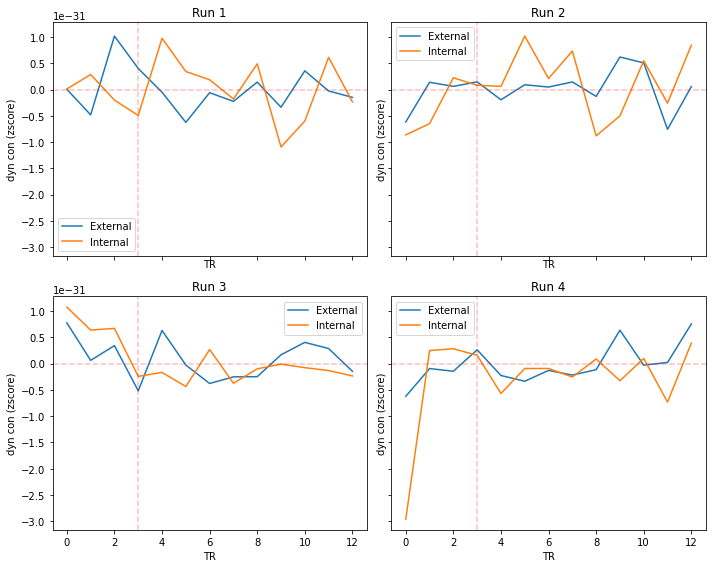

In [127]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex = True, sharey = True)
mov_name = 'sherlock'

for runz in range(0,4):
    # adjust index
    run = runz + 1
    
    ## Average ##
    ext_av = av_nan(m_rep_ext[run][mov_name][0])
    int_av = av_nan(m_rep_int[run][mov_name][0])
    
    ## get lines ##
    #ext_av = np.mean(m_rep_ext[run][mov_name][0], axis = 1).T
    #int_av = np.mean(m_rep_int[run][mov_name][0], axis = 1).T

    # Plot the first subplot (top-left)
    axs[int(runz / 2), int(runz % 2)].plot(ext_av, label='External')
    axs[int(runz / 2), int(runz % 2)].plot(int_av, label='Internal')
    axs[int(runz / 2), int(runz % 2)].set_title(f'Run {run}')
    axs[int(runz / 2), int(runz % 2)].set_xlabel('TR')
    axs[int(runz / 2), int(runz % 2)].set_ylabel('dyn con (zscore)')
    axs[int(runz / 2), int(runz % 2)].axvline(x=3, color='red', linestyle='--', alpha = .25)  # Vertical line at the third tick
    axs[int(runz / 2), int(runz % 2)].axhline(y=0, color='red', linestyle='--', alpha = .25) 
    axs[int(runz / 2), int(runz % 2)].legend()
    
# Adjust the layout and spacing between subplots
plt.tight_layout()

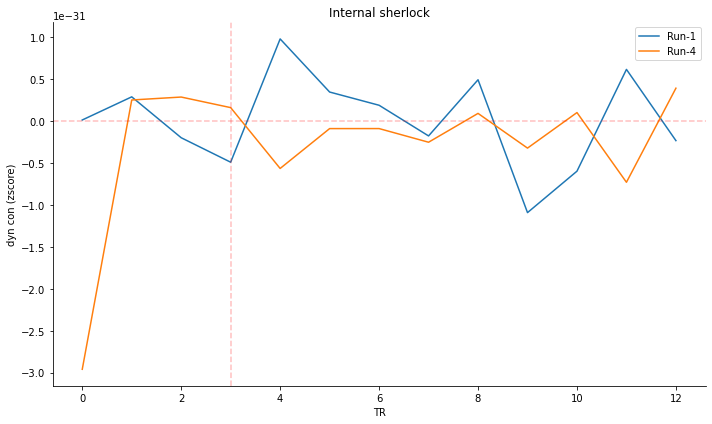

In [126]:
mov_name = 'sherlock'
cond = 'Internal'
runs = [1, 4]  # Choose the specific run you want to plot


## Average ##
# set outer loop #
if cond == 'External':
    target_dict = m_rep_ext
else:
    target_dict = m_rep_int


fig, ax = plt.subplots(figsize=(10, 6))

# Plot the graph
for run in runs:
    cond_av = av_nan(target_dict[run][mov_name][0])
    plt.plot(cond_av, label=f'Run-{run}')
plt.title(f'{cond} {mov_name}')
plt.xlabel('TR')
plt.ylabel('dyn con (zscore)')
plt.axvline(x=3, color='red', linestyle='--', alpha=0.25)  # Vertical line at the third tick
plt.axhline(y=0, color='red', linestyle='--', alpha=0.25)
plt.legend()

# Adjust the layout
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()


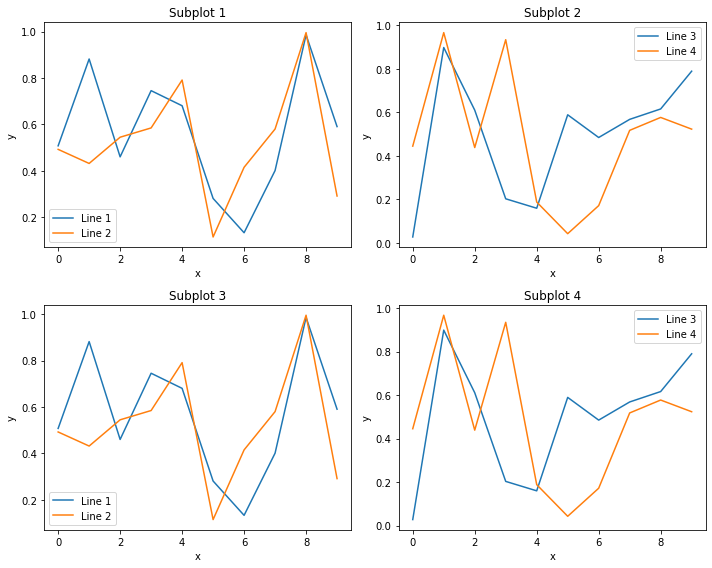

In [100]:

# Generate some random data for the line plots
x = np.arange(0, 10)
y1 = np.random.rand(10)
y2 = np.random.rand(10)
y3 = np.random.rand(10)
y4 = np.random.rand(10)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the first subplot (top-left)
axs[0, 0].plot(x, y1, label='Line 1')
axs[0, 0].plot(x, y2, label='Line 2')
axs[0, 0].set_title('Subplot 1')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].legend()

# Plot the second subplot (top-right)
axs[0, 1].plot(x, y3, label='Line 3')
axs[0, 1].plot(x, y4, label='Line 4')
axs[0, 1].set_title('Subplot 2')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
axs[0, 1].legend()

# Plot the third subplot (bottom-left)
axs[1, 0].plot(x, y1, label='Line 1')
axs[1, 0].plot(x, y2, label='Line 2')
axs[1, 0].set_title('Subplot 3')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
axs[1, 0].legend()

# Plot the fourth subplot (bottom-right)
axs[1, 1].plot(x, y3, label='Line 3')
axs[1, 1].plot(x, y4, label='Line 4')
axs[1, 1].set_title('Subplot 4')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
axs[1, 1].legend()

# Adjust the layout and spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



# ISC ANAL

In [44]:
#anal = m_rep_int[4]['sherlock']
anal = m_rep_ext[4]['sherlock']

anal.shape

(13, 3404, 18)

In [45]:
# Transpose input data to compute intersubject pattern correlation
ispcs = isfc(np.rollaxis(anal, 1, 0),
                    pairwise=False, vectorize_isfcs=False,
                    summary_statistic='mean')

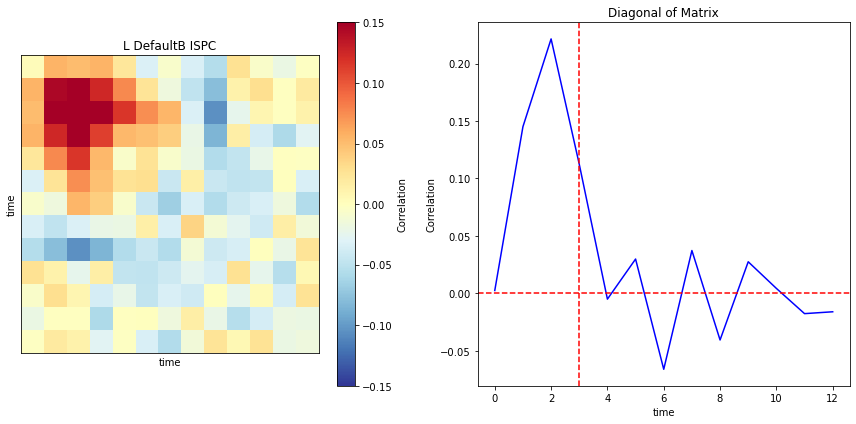

In [46]:
# Plot time-point-by-time-point intersubject pattern correlation
vmin, vmax = -0.15, 0.15

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Matrix
ispc = ispcs  # Choose the matrix to plot (intact_ispcs or scram_ispcs)
title = f'{net_lab} ISPC'  # Choose the appropriate title
image = axs[0].matshow(ispc, vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
axs[0].set_title(title)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('time')
axs[0].set_ylabel('time')
cbar = plt.colorbar(image, ax=axs[0])  # Add colorbar
cbar.set_label('Correlation')  # Set colorbar label

# Second plot: Seaborn lineplot with vertical line
diagonal = np.diagonal(ispc)
time_points = np.arange(len(diagonal))
axs[1] = sns.lineplot(x=time_points, y=diagonal, color='blue')
axs[1].set_title('Diagonal of Matrix')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Correlation')
axs[1].axvline(x=3, color='red', linestyle='--')  # Vertical line at the third tick
axs[1].axhline(y=0, color='red', linestyle='--')  # Horizotnal line at 0


plt.tight_layout()
plt.show()
